In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import torch
import zfocus as zf
from scipy.ndimage import gaussian_filter

In [ ]:
from zse.utils.data_utils import read_h5, z_range_from_threshold

In [ ]:
def plot_maps(img, path=None):
    plt.figure(dpi=100)
    plt.imshow(img)
    plt.colorbar(pad=0.03)
    if path is not None:
        plt.savefig(path, bbox_inches='tight')
    plt.show()

In [ ]:
home = "/p/fastdata/bigbrains/personal/crijnen1"
data_root = f"{home}/data"
dest = f"../../reports/results/brain/tissue_localization"

In [ ]:
path = f"{data_root}/bigbrain_1micron/29/test/blurry/B21_0228_y25225_x17625.hdf5"
vol = read_h5(path)

In [ ]:
# Sliding window
window_size = 128
window_stride = 64
win, x_range, y_range = zf.sliding_window_view(vol, (window_size,) * 2, stride=window_stride, axis=(0, 1), return_ranges=True)

In [ ]:
thresh = 0.6
bins = 24
hist = zf.frequency_histogram(win, (3, 4), bins=bins)
norm_hist = hist / hist.max(2, keepdims=True)  # normalize over z-axis

sharpness = norm_hist[..., -8:].mean(-1)

start_map, stop_map = z_range_from_threshold(sharpness, thresh, exact=True)

In [33]:
# interpolate the sharpness back to original values
shape = vol.shape[:2]
full_start_map = zf.interpolate_index_map(start_map, shape, x_range, y_range)
full_stop_map = zf.interpolate_index_map(stop_map, shape, x_range, y_range)

# smooth the maps
full_start_map = gaussian_filter(full_start_map, sigma=31)
full_stop_map = gaussian_filter(full_stop_map, sigma=31)

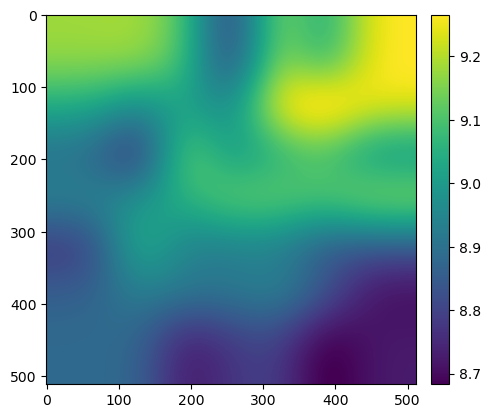

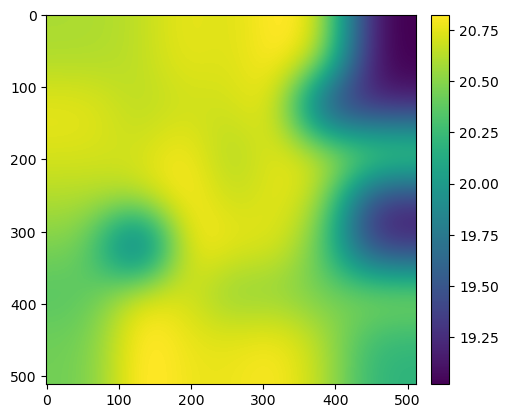

In [34]:
plot_maps(full_start_map, f"{dest}/full_start_map.png")
plot_maps(full_stop_map, f"{dest}/full_stop_map.png")

In [35]:
resampled_vol = zf.resample_vol_irregular(vol, full_start_map, full_stop_map, 20)

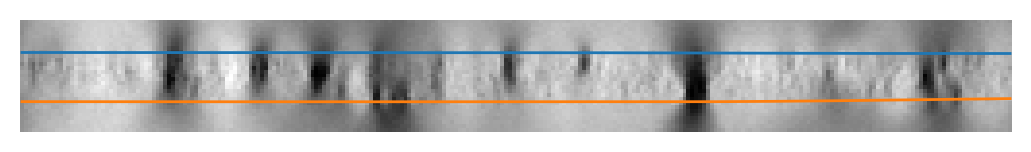

In [54]:
# imshow
plt.figure(dpi=200)
plt.imshow(vol[128, 128:128+256].transpose(1,0), cmap="gray")
plt.axis("off")
# plot borders
stam = full_start_map[128, 128:128+256]
plt.plot(range(len(stam)), stam - 1, linewidth=1)  # one before interval
stom = full_stop_map[128, 128:128+256]
plt.plot(range(len(stom)), stom, linewidth=1)  # one after interval
plt.savefig(f"{dest}/xz.png", bbox_inches='tight', pad_inches=0)
plt.show()

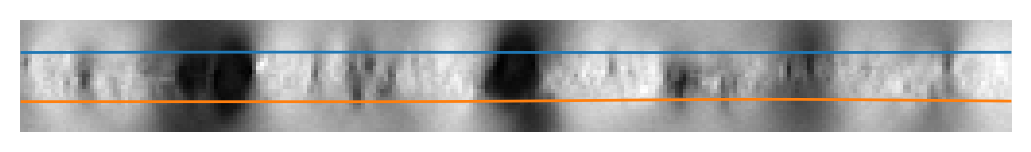

In [55]:
# imshow
plt.figure(dpi=200)
plt.imshow(vol[128:128+256, 128].transpose(1,0), cmap="gray")
plt.axis("off")
# plot borders
stam = full_start_map[128:128+256, 128]
plt.plot(range(len(stam)), stam - 1, linewidth=1)  # one before interval
stom = full_stop_map[128:128+256, 128]
plt.plot(range(len(stom)), stom, linewidth=1)  # one after interval
plt.savefig(f"{dest}/yz.png", bbox_inches='tight', pad_inches=0)
plt.show()